In [1]:
! pip install xgboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer

In [3]:
data = pd.read_csv('../Datasets/Suicidal text Dataset/Suicide_Detection.csv')


In [4]:
data

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [5]:
data.shape

(232074, 3)

In [6]:
df = data.sample(n=80000, random_state=42)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 74414 to 128657
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80000 non-null  int64 
 1   text        80000 non-null  object
 2   class       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [8]:
df['Unnamed: 0'].is_unique

True

In [9]:
df.drop(columns = 'Unnamed: 0',inplace=True)

In [10]:
df.head()

,text,class
74414,I Don't know?7? Months self harm free and the ...,suicide
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,I've honestly got no idea what to do anymore.I...,suicide
30673,Do you ever just cry? Like you just think abou...,non-suicide


In [11]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [12]:
df.duplicated().sum()

0

class
suicide        40000
non-suicide    40000
Name: count, dtype: int64


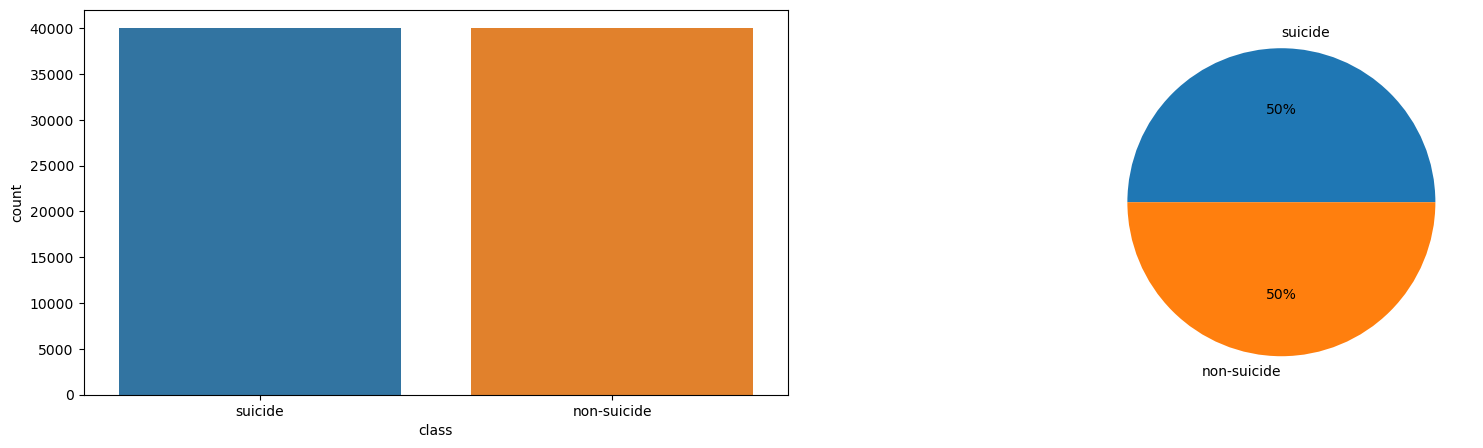

In [13]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

In [14]:
df['text']= df['text'].str.lower()

In [15]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

In [18]:
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x : [ps.stem(i) for i in x])

In [19]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [20]:
df.head()

,text,class
74414,dont know7 month self harm free urg get strong...,suicide
149516,start becom rich start compani becom 16 afford...,non-suicide
12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
14043,ive honestli got idea anymoreit feel everyon f...,suicide
30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [21]:
# Saved the cleaned dataset.
df.to_csv('file1.csv')

In [22]:
dfnew = pd.read_csv('file1.csv')
dfnew.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,suicide
1,149516,start becom rich start compani becom 16 afford...,non-suicide
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [23]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80000 non-null  int64 
 1   text        79990 non-null  object
 2   class       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [24]:
ind = dfnew[dfnew['text'].isnull()].index

In [25]:
df.iloc[ind]

,text,class
102482,,suicide
205215,,non-suicide
11476,,non-suicide
181086,,non-suicide
216154,,non-suicide
9592,,non-suicide
47558,,non-suicide
231259,,non-suicide
119023,,non-suicide
408,,non-suicide


In [26]:
dfnew.dropna(inplace=True)

In [27]:
x,y = dfnew['text'],dfnew['class']

In [28]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [29]:
# Save the model
with open('../models/Suicide Indicator Model/tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)    

In [30]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

In [31]:
X_train.shape,X_test.shape

((55993, 4287), (23997, 4287))

In [32]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.9042916078795564
Testing score: 0.8918614826853357


              precision    recall  f1-score   support

 non-suicide       0.89      0.90      0.89     12039
     suicide       0.90      0.89      0.89     11958

    accuracy                           0.89     23997
   macro avg       0.89      0.89      0.89     23997
weighted avg       0.89      0.89      0.89     23997



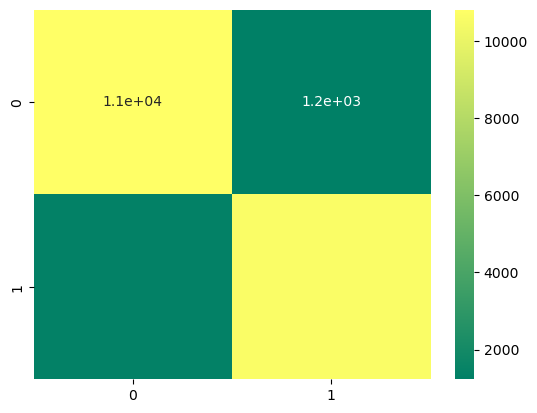

In [33]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [34]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
classifiers.fit(X_train, y_train)
print('Training score:',classifiers.score(X_train, y_train))
print('Testing score:',classifiers.score(X_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.7580054649688354
Testing score: 0.749760386715006
RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=3,
                       n_estimators=5)


              precision    recall  f1-score   support

 non-suicide       0.71      0.86      0.77     12039
     suicide       0.82      0.64      0.72     11958

    accuracy                           0.75     23997
   macro avg       0.76      0.75      0.75     23997
weighted avg       0.76      0.75      0.75     23997



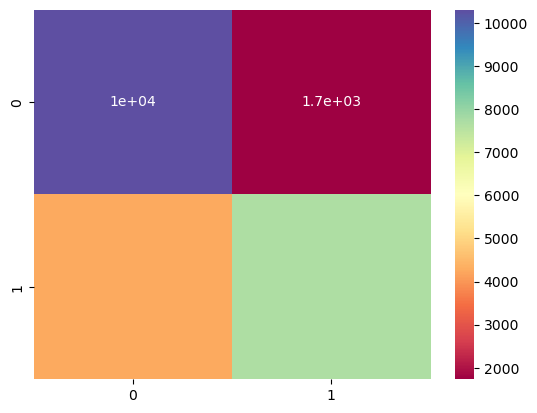

In [35]:
y_act=y_test
y_pred=classifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral')
print(classification_report(y_act,y_pred))

In [36]:
def preprocess(inp):
    inp = inp.lower() #convert to lower case 
    inp = inp.replace(r'[^\w\s]+', '') #remove punctuations
    inp = [word for word in inp.split() if word not in (stop_words)] #tokenize the sentence
    inp = ' '.join([ps.stem(i) for i in inp]) #stremming
    inputToModel = vectorizer.transform([inp]).toarray() #transform to vector form
    return inputToModel

In [37]:
def app(input_text):
    # Define the input text box
    print('Input : ',input_text) #take input from user
    processed_array = preprocess(input_text) #preprocess the text 
    predict = VotingClassifiers.predict(processed_array) #Model prediction
    print('Output : ', predict[0])
    return predict[0]
    

In [38]:
# Save the functions and model using pickle
with open('../models/Suicide Indicator Model/sui_prediction.pkl', 'wb') as f:
    pickle.dump({'model': VotingClassifiers}, f)


In [39]:
app(' I shall hang myself.')

Input :   I shall hang myself.
Output :  suicide


'suicide'

In [40]:
app('Have a nice day! Happy Coding😊')

Input :  Have a nice day! Happy Coding😊
Output :  non-suicide


'non-suicide'